# 傾向スコアを用いた因果推論

- 概要
    - バイアスのある人工データを生成し，下記の手法それぞれで因果効果を推定．結果を比較する．
      - 単純な群間比較
      - 傾向スコアマッチング（非復元抽出/復元抽出）
      - IPW (Inverse Probability Weighting) 法
      - OW (Overlap Weighting) 法

- 参考
 - 因果効果の推定！Rで実践 - 傾向スコア，マッチング，IPW推定量
    - https://tomoshige-n.hatenablog.com/entry/2016/06/19/033252）
 - 傾向スコアを使った因果効果の推定方法
    - https://qiita.com/StoneRIeverKS/items/80c805676ed4dc5f8de4

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from statsmodels.regression.linear_model import WLS
from sklearn.metrics import roc_auc_score

## 0. Functions etc...

In [ ]:
# 傾向スコアの分布を描画する関数
def prop_score_dist(df, ps):
    """
    TG/CGの傾向スコアの分布を描く。

    Parameters
    ----------
    df: DataFrame
      描画対象データフレーム
    ps:
      傾向スコアのカラム名
    
    """
    plt.hist(df[df["z"] == 0][ps], bins = 50, alpha = 0.5, label = "CG")
    plt.hist(df[df["z"] == 1][ps], bins = 50, alpha = 0.5, label = "TG")
    plt.legend(loc = "best")
    plt.xlabel("Propensity score")
    plt.ylabel("Count")

In [ ]:
# 度数分布表を作成する関数
def freq_dist(data, class_width = None):
    """
    度数分布表を出力する。

    Parameters
    ----------
    data: array
      度数分布表を作成したい変数のデータ
    class_width: 
      階級幅（スタージェスの公式で求める場合は何も渡さなくてOK）
    
    Returns
    ----------
    bins: array
      境界値
    freq_df: data frame
      度数分布表（カラム：階級値（bin）、度数（freq）、相対度数（rel_freq））
    """
    data = np.asarray(data)

    # スタージェスの公式で階級数を求め、階級幅を決定する場合
    if class_width is None:
        class_size = int(np.log2(data.size).round()) + 1            # 階級数
        class_width = round((data.max() - data.min()) / class_size) # 階級幅
    
    bins = np.arange(data.min(), data.max() + class_width, class_width) # 境界値
    hist = np.histogram(data, bins)[0]                                  # 度数
    freq_df = pd.DataFrame({"bin": (bins[1:] + bins[:-1]) / 2, 
                            "freq": hist,
                            "rel_freq": hist / hist.sum()}, 
                            index = pd.Index([f"{round(bins[i], 2)}-{round(bins[i+1], 2)}" for i in range(hist.size)]))

    # 境界値と度数分布表を出力
    return bins, freq_df

In [ ]:
# 調整前後における各特徴量の分布を描く関数（※マッチング以外の手法には未対応）
def covariate_dist(df_bf, df_af, cov_list_vis):
    """
    マッチング前後における各特徴量の分布を描く関数。
    質的変数については積み上げ横棒グラフで、量的変数については度数分布表を作成し棒グラフで描画する。
    
    parameters
    ----------
    df_bf: DataFrame
      マッチング前のデータ
    df_af: DataFrame
      マッチング後のデータ
    cov_list_vis: List
      分布を可視化する特徴量
    """
    # マッチング前/後のdfにカラムTGCGを追加
    df_bf["TGCG"] = ["TG" if x == 1 else "CG" for x in df_bf["z"]]
    df_af["TGCG"] = ["TG" if x == 1 else "CG" for x in df_af["z"]]

    # 描画
    n = len(cov_list_vis)
    ncol = 4
    nrow = int(np.ceil(n / 4))

    fig = plt.figure(figsize=(20, 6))
    outer = gridspec.GridSpec(nrow, ncol, wspace = 0.2, hspace = 0.3)

    # Outer loop
    for i in range(n):
        
        # 描画する特徴量を選択
        cov = cov_list_vis["cov_name"][i]

        # 質的変数の場合
        if cov_list_vis["categorical"][i] == 1:

            # 2×1グリッド
            inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[i], wspace = 0.1, hspace = 0.4)

            # データ：調整前
            bf = pd.crosstab(index = df_bf["TGCG"], columns = df_bf[cov])
            bf = bf.div(bf.sum(axis = 1), axis = 0) # 正規化

            # 描画：調整前
            n_rows_bf, n_cols_bf = bf.shape
            positions_bf = np.arange(n_rows_bf)
            colors_bf = plt.get_cmap("tab20c")(np.linspace(0, 1, n_cols_bf))
            offsets_bf = np.zeros(n_rows_bf, dtype = bf.values.dtype)

            ax1 = plt.Subplot(fig, inner[0])
            ax1.set_yticks(positions_bf)
            ax1.set_yticklabels(bf.index)
            ax1.set_title("Feature: " + cov + "\n" + "Before")

            for i in range(len(bf.columns)):

                # 棒グラフを描画
                bar = ax1.barh(positions_bf, bf.iloc[:, i], left = offsets_bf, color = colors_bf[i])
                offsets_bf += bf.iloc[:, i]

                # 棒グラフのラベルを描画
                for rect in bar:
                    cx = rect.get_x() + rect.get_width() / 2
                    cy = rect.get_y() + rect.get_height() / 2
                    ax1.text(cx, cy, bf.columns[i], color = "k", ha = "center", va = "center")
            
            fig.add_subplot(ax1)

            # データ：調整後
            af = pd.crosstab(index = df_af["TGCG"], columns = df_af[cov])
            af = af.div(af.sum(axis = 1), axis = 0) # 正規化

            # 描画：調整後
            n_rows_af, n_cols_af = af.shape
            positions_af = np.arange(n_rows_af)
            colors_af = plt.get_cmap("tab20c")(np.linspace(0, 1, n_cols_af))
            offsets_af = np.zeros(n_rows_af, dtype = af.values.dtype)

            ax2 = plt.Subplot(fig, inner[1])
            ax2.set_yticks(positions_af)
            ax2.set_yticklabels(af.index)
            ax2.set_title("After")

            for i in range(len(af.columns)):

                # 棒グラフを描画
                bar = ax2.barh(positions_af, af.iloc[:, i], left = offsets_af, color = colors_af[i])
                offsets_af += af.iloc[:, i]

                # 棒グラフのラベルを描画
                for rect in bar:
                    cx = rect.get_x() + rect.get_width() / 2
                    cy = rect.get_y() + rect.get_height() / 2
                    ax2.text(cx, cy, af.columns[i], color = "k", ha = "center", va = "center")
            
            fig.add_subplot(ax2)
        
        # 量的変数の場合
        else: 
            
            # 調整前TG/CG、調整後TG/CGの度数分布表
            class_width = df_bf[cov].max() / 15
            bins, bf = freq_dist(df_bf[cov], class_width) # 棒の本数を固定
            freq_table = pd.DataFrame({
                "bin": bf["bin"], 
                "rel_freq_cg_bf": np.histogram(df_bf[cov][df_bf["z"] == 0], bins)[0], 
                "rel_freq_tg_bf": np.histogram(df_bf[cov][df_bf["z"] == 1], bins)[0], 
                "rel_freq_cg_af": np.histogram(df_af[cov][df_af["z"] == 0], bins)[0], 
                "rel_freq_tg_af": np.histogram(df_af[cov][df_af["z"] == 1], bins)[0]
            })

            # 相対度数に変換
            freq_table["rel_freq_cg_bf"] = freq_table["rel_freq_cg_bf"] / freq_table["rel_freq_cg_bf"].sum()
            freq_table["rel_freq_tg_bf"] = freq_table["rel_freq_tg_bf"] / freq_table["rel_freq_tg_bf"].sum()
            freq_table["rel_freq_cg_af"] = freq_table["rel_freq_cg_af"] / freq_table["rel_freq_cg_af"].sum()
            freq_table["rel_freq_tg_af"] = freq_table["rel_freq_tg_af"] / freq_table["rel_freq_tg_af"].sum()

            # 2×1グリッド
            inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[i], wspace = 0.1, hspace = 0.4)

            # 調整前
            ax1 = plt.Subplot(fig, inner[0])
            ax1.bar(freq_table["bin"], freq_table["rel_freq_cg_bf"], width = class_width, alpha = 0.5, color = "blue", label = "CG")
            ax1.bar(freq_table["bin"], freq_table["rel_freq_tg_bf"], width = class_width, alpha = 0.5, color = "orange", label = "TG")
            ax1.axvline(x = df_bf[cov][df_bf["z"] == 0].mean(), linestyle = "dashed", linewidth = 1, color = "blue")
            ax1.axvline(x = df_bf[cov][df_bf["z"] == 1].mean(), linestyle = "dashed", linewidth = 1, color = "orange")
            ax1.set_title("Feature: " + cov + "\n" + "Before")
            ax1.legend(loc = "best")

            fig.add_subplot(ax1)

            # 調整後
            ax2 = plt.Subplot(fig, inner[1])
            ax2.bar(freq_table["bin"], freq_table["rel_freq_cg_af"], width = class_width, alpha = 0.5, color = "blue", label = "CG")
            ax2.bar(freq_table["bin"], freq_table["rel_freq_tg_af"], width = class_width, alpha = 0.5, color = "orange", label = "TG")
            ax2.axvline(x = df_af[cov][df_af["z"] == 0].mean(), linestyle = "dashed", linewidth = 1, color = "blue")
            ax2.axvline(x = df_af[cov][df_af["z"] == 1].mean(), linestyle = "dashed", linewidth = 1, color = "orange")
            ax2.set_title("After")
            ax2.legend(loc = "best")

            fig.add_subplot(ax2)

In [ ]:
# 回帰分析(OLS)の推定結果を返す関数
def reg_ols(dep_var, exp_var):
    """
    OLSによる回帰分析を実行する。

    Parameters
    ----------
    dep_var:
      目的変数
    exp_var:
      説明変数
    
    """

    # OLS(Ordinary Least Squares)
    Y = dep_var
    X = sm.add_constant(exp_var)
    result = sm.OLS(Y, X).fit()
    print(result.summary())

In [ ]:
# 回帰分析(WLS)の推定結果を返す関数
def reg_wls(dep_var, exp_var, ow_flg):
    """
    WLSによる回帰分析を実行する。

    Parameters
    ----------
    dep_var:
      目的変数
    exp_var:
      説明変数
    ow_flg:
      1ならOWのウェイトを計算，それ以外ならIPWのウェイトを計算
    
    """

    # ウェイト計算
    if ow_flg == 0:
        weight = (df["z"] / df["e_hat"]) + ((1 - df["z"]) / (1 - df["e_hat"])) # IPWの場合
    else:
        weight = (df["z"] * (1 - df["e_hat"])) + ((1 - df["z"]) * df["e_hat"]) # OWの場合
    
    # WLS(Weighted Least Squares)
    Y = dep_var
    X = sm.add_constant(exp_var)
    result = sm.WLS(Y, X, weights = weight).fit()
    print(result.summary())

In [ ]:
# 傾向スコアマッチング（最近傍マッチング）を実行するクラス
class PropensityScoreMatching:

    # 傾向スコアマッチングを実行
    def __init__(self, df, uid, cov_list, z, ps, rs, nrep):
        """
        非復元抽出 or 復元抽出による傾向スコアマッチングを実行する。

        Parameters
        ----------
        df: data frame
          ユーザID、介入変数、特徴量、傾向スコアの推定値をカラムとして持つデータフレーム
        uid: array
          ユーザID
        cov_list: list
          特徴量リスト
        z: array
          介入変数
        ps: array
          傾向スコアの推定値
        rs: array
          結果変数
        nrep:
          非復元抽出flg（0 or 1）
        """
        self.df = df
        self.uid = uid
        self.cov_list = cov_list
        self.z = z
        self.ps = ps
        self.rs = rs
        self.nrep = nrep

        # マッチング後のTG/CGテーブル
        self.df_matched_tg = pd.DataFrame(index = [], columns = self.df.columns)
        self.df_matched_cg = pd.DataFrame(index = [], columns = self.df.columns)

        # マッチング後の傾向スコアの差の絶対値を格納する配列
        self.df_score_diff = np.empty(0, dtype = "float64")

        # 介入の有無でデータフレームを分割（いずれもインデックスをゼロスタートにしておく）
        self.df0 = self.df[self.df[self.z] == 0].reset_index(drop = True)
        self.df1 = self.df[self.df[self.z] == 1].reset_index(drop = True)

        # TGの人数とCGの人数で少ない方の人数を取得
        self.num_matching = min(self.df0.shape[0], self.df1.shape[0])

        # 最近傍マッチングで傾向スコアマッチング
        # Step1. TGからユーザiをとってくる
        # Step2. ユーザiの傾向スコアと、CGにおける各ユーザの傾向スコアの差の絶対値を計算
        # Step3. 差が最小のユーザjを特定してマッチさせる（ペアをつくる）
        # Step4. Step1～3をnum_matching回繰り返す
        for i in range(self.num_matching):

            # TGのユーザiをマッチング後のTGテーブルに格納
            tg_user = pd.DataFrame(self.df1.iloc[i]).T
            self.df_matched_tg = pd.concat([self.df_matched_tg, tg_user])

            # TGのユーザiの傾向スコアを取得
            eps1 = self.df1[self.ps][i]

            # CGのすべてのユーザjについて傾向スコアの差の絶対値を計算
            abs_eps_list = [abs(eps1 - eps0) for eps0 in self.df0[self.ps]]
              
            # 傾向スコアの差の絶対値が最小となるようなインデックスと傾向スコアの差，対応するself.df0の行を取得
            min_index = abs_eps_list.index(min(abs_eps_list))
            min_score_diff = abs_eps_list[min_index]
            min_user = pd.DataFrame(self.df0.iloc[min_index]).T

            # 傾向スコアの差の絶対値を格納
            self.df_score_diff = np.append(self.df_score_diff, min_score_diff) 

            # min_userをマッチング後のCGテーブルに格納
            self.df_matched_cg = pd.concat([self.df_matched_cg, min_user])

            # self.df0からmin_userを削除してインデックスをリセット（非復元抽出の場合）
            if self.nrep == 1:
                self.df0 = self.df0.drop(min_index).reset_index(drop = True)
        
        # 傾向スコアの距離が閾値以下のペアのみ残す（キャリパーマッチング）
        caliper = 0.1 # 閾値
        self.df_matched_tg = self.df_matched_tg[self.df_score_diff <= caliper]
        self.df_matched_cg = self.df_matched_cg[self.df_score_diff <= caliper]
        
        # df_matched_tgとdf_matched_cgをconcat
        self.df_matched = pd.concat([self.df_matched_tg, self.df_matched_cg]).reset_index(drop = True)

    # マッチング後のユーザリストを取得
    def matched_user_list(self):
        """
        マッチング後のユーザリストを出力する。
        """
        # 結果変数と介入変数を適切な型にしておく(後の回帰のため)
        self.df_matched[self.rs] = self.df_matched[self.rs].astype("float")
        self.df_matched[self.z] = self.df_matched[self.z].astype("int")

        return self.df_matched
    
    # 各群の結果変数の平均を取得
    def get_effect(self):
        self.mean0 = self.df_matched[self.df_matched[self.z] == 0][self.rs].mean()
        self.mean1 = self.df_matched[self.df_matched[self.z] == 1][self.rs].mean()
        return self.mean1 - self.mean0
    
    # Covariate Balance Check（標準化平均差：Austin(2011)によるもの）
    def standardized_difference(self):
        """
        特徴量ごとにマッチング前後における標準化平均差を計算し、可視化する。
        """
        # 共変量調整前
        denom_bf = np.sqrt( (np.var(self.df[self.df[self.z] == 1][self.cov_list]) + np.var(self.df[self.df[self.z] == 0][self.cov_list])) / 2 )
        self.cov_sd_bf = abs( (np.mean(self.df[self.df[self.z] == 1][self.cov_list]) - np.mean(self.df[self.df[self.z] == 0][self.cov_list]) ) / denom_bf )

        # 共変量調整後
        denom_af = np.sqrt( (np.var(self.df_matched[self.df_matched[self.z] == 1][self.cov_list]) + np.var(self.df_matched[self.df_matched[self.z] == 0][self.cov_list])) / 2 )
        self.cov_sd_af = abs( (np.mean(self.df_matched[self.df_matched[self.z] == 1][self.cov_list]) - np.mean(self.df_matched[self.df_matched[self.z] == 0][self.cov_list])) / denom_af )

        # データフレーム化
        sd_df = pd.DataFrame({
            "before": self.cov_sd_bf, 
            "after": self.cov_sd_af
        })
        sd_df = sd_df.fillna(0).reset_index()

        # 作図：love plot
        plt.figure(figsize=(6, 4))
        plt.scatter(sd_df['index'], sd_df['before'], label = 'not adjusted')
        plt.scatter(sd_df['index'], sd_df['after'], label = 'adjusted')
        plt.hlines([0.1], xmin = -1, xmax = len(self.cov_list), color = "red", linestyle = "dashed", linewidth = 1)
        plt.legend()
        plt.ylabel('Standardized mean difference')
        plt.xlabel('Covariate')
        plt.grid(True)
        plt.show()

        return sd_df

In [ ]:
# IPW(OW)推定を実行するクラス
class Weighting:
    
    def __init__(self, df, cov_list, z, ps, rs, ow):

        """
        Parameters
        ----------
        df: data frame
          結果変数、介入変数、特徴量、傾向スコアの推定値をカラムとして持つデータフレーム
        cov_list: list
          特徴量リスト
        z: array
          介入変数
        ps: array
          傾向スコアの推定値
        rs: array
          結果変数
        ow:
          OWフラグ(0 or 1)
        """
    
        self.df = df
        self.cov_list = cov_list
        self.z = z
        self.ps = ps
        self.rs = rs
        self.ow = ow
    
        # 介入の有無でデータフレームを分割
        self.df0 = self.df[self.df[z] == 0]
        self.df1 = self.df[self.df[z] == 1]
    
    # 各群のIPW(OW)推定量計算
    def estimator(self, column):

        # For IPW estimation
        if self.ow == 0:

          est_tg = np.sum((self.df1[self.z] * self.df1[column]) / self.df1[self.ps]) / np.sum(self.df1[self.z] / self.df1[self.ps])
          est_cg = np.sum(((1 - self.df0[self.z]) * self.df0[column]) / (1 - self.df0[self.ps])) / np.sum((1 - self.df0[self.z]) / (1 - self.df0[self.ps]))
          return est_tg, est_cg
        
        # For OW estimator
        else:

          est_tg = np.sum(self.df1[self.z] * self.df1[column] * (1 - self.df1[self.ps])) / np.sum(self.df1[self.z] * (1 - self.df1[self.ps]))
          est_cg = np.sum((1 - self.df0[self.z]) * self.df0[column] * self.df0[self.ps]) / np.sum((1 - self.df0[self.z]) * self.df0[self.ps])
          return est_tg, est_cg

    # 効果推定値算出
    def get_effect(self):
        self.est_mean1, self.est_mean0 = self.estimator(column = self.rs)
        return self.est_mean1 - self.est_mean0

    # Covariate Balance Check（標準化平均差を計算）
    # Ref: Austin(2011, Multivariate Behav. Res.)
    def standardized_difference(self):
        """
        特徴量ごとに調整前後における標準化平均差を計算し、可視化する。
        """
        # 調整前
        #-----------------------------------------------------------------------
        numer_bf = np.mean(self.df1[self.cov_list]) - np.mean(self.df0[self.cov_list])
        denom_bf = np.sqrt( (np.var(self.df1[self.cov_list]) + np.var(self.df0[self.cov_list])) / 2 )
        self.cov_sd_bf = abs( numer_bf / denom_bf )

        # 調整後
        #-----------------------------------------------------------------------
        
        # For IPW estimation
        if self.ow == 0:

            # Weighted covariates
            weighted_cov1 = self.df1[self.cov_list].apply(lambda x: x / self.df1[self.ps])
            weighted_cov0 = self.df0[self.cov_list].apply(lambda x: x / (1 - self.df0[self.ps]))

            # Numerator
            mu_1 = np.sum(weighted_cov1) / np.sum(1 / self.df1[self.ps])
            mu_0 = np.sum(weighted_cov0) / np.sum(1 / (1 - self.df0[self.ps]))
            numer_af = mu_1 - mu_0

            # Denominator
            # Ref: Austin and Stuart(2015, Stat. Med.)
            s1_af_coef = np.sum(1 / self.df1[self.ps]) / ( (np.sum(1 / self.df1[self.ps]) * np.sum(1 / self.df1[self.ps])) - np.sum((1 / self.df1[self.ps]) * (1 / self.df1[self.ps])) )
            s1_temp1 = (self.df1[self.cov_list] - mu_1) * (self.df1[self.cov_list] - mu_1)
            s1_temp2 = s1_temp1.apply(lambda x: x * (1 / self.df1[self.ps]))
            s1_af = s1_af_coef * np.sum(s1_temp2)

            s0_af_coef = np.sum(1 / (1 - self.df0[self.ps])) / ( (np.sum(1 / (1 - self.df0[self.ps])) * np.sum(1 / (1 - self.df0[self.ps]))) - np.sum((1 / (1 - self.df0[self.ps])) * (1 / (1 - self.df0[self.ps]))) )
            s0_temp1 = (self.df0[self.cov_list] - mu_0) * (self.df0[self.cov_list] - mu_0)
            s0_temp2 = s0_temp1.apply(lambda x: x * (1 / (1 - self.df0[self.ps])))
            s0_af = s0_af_coef * np.sum(s0_temp2)

            denom_af = np.sqrt( (s1_af + s0_af) / 2 )

            self.cov_sd_af = abs( numer_af / denom_af )
        
        # For OW estimation
        else:

            # Weighted covariates
            weighted_cov1 = self.df1[self.cov_list].apply(lambda x: x * (1 - self.df1[self.ps]))
            weighted_cov0 = self.df0[self.cov_list].apply(lambda x: x * self.df0[self.ps])

            # Numerator
            mu_1 = np.sum(weighted_cov1) / np.sum((1 - self.df1[self.ps]) * self.df1[self.z])
            mu_0 = np.sum(weighted_cov0) / np.sum(self.df0[self.ps] * (1 - self.df0[self.z]))
            numer_af = mu_1 - mu_0

            # Denominator
            s1_af_coef = np.sum(1 - self.df1[self.ps]) / ( (np.sum(1 - self.df1[self.ps]) * np.sum(1 - self.df1[self.ps])) - np.sum((1 - self.df1[self.ps]) * (1 - self.df1[self.ps])) )
            s1_temp1 = (self.df1[self.cov_list] - mu_1) * (self.df1[self.cov_list] - mu_1)
            s1_temp2 = s1_temp1.apply(lambda x: x * (1 - self.df1[self.ps]))
            s1_af = s1_af_coef * np.sum(s1_temp2)

            s0_af_coef = np.sum(self.df0[self.ps]) / ( (np.sum(self.df0[self.ps]) * np.sum(self.df0[self.ps])) - np.sum(self.df0[self.ps] * self.df0[self.ps]) )
            s0_temp1 = (self.df0[self.cov_list] - mu_0) * (self.df0[self.cov_list] - mu_0)
            s0_temp2 = s0_temp1.apply(lambda x: x * self.df0[self.ps])
            s0_af = s0_af_coef * np.sum(s0_temp2)

            denom_af = np.sqrt( (s1_af + s0_af) / 2 )

            self.cov_sd_af = abs( numer_af / denom_af )

        # データフレーム化
        sd_df = pd.DataFrame({
            "Before": self.cov_sd_bf, 
            "After": self.cov_sd_af
        })
        sd_df = sd_df.reset_index()

        # 作図：love plot
        plt.figure(figsize=(6, 4))
        plt.scatter(sd_df['index'], sd_df['Before'], label = 'not adjusted')
        plt.scatter(sd_df['index'], sd_df['After'], label = 'adjusted')
        plt.hlines([0.1], xmin = -1, xmax = len(self.cov_list), color = "red", linestyle = "dashed", linewidth = 1)
        plt.legend()
        plt.ylabel('Standardized mean difference')
        plt.xlabel('Covariate')
        plt.grid(True)
        plt.show()

        return sd_df

## 1. バイアスのある人工データ生成
- 真の効果は負であるにもかかわらず，単純な群間比較ではあたかも正の効果があるように見えてしまう人工データを生成する


In [ ]:
# Seed
np.random.seed(1)

# サンプル数
n = 10000

# 特徴量：X = [x1, x2, x3, x4]
# x1, x2: 量的変数
# x3, x4: 質的変数
x1 = np.random.randn(n)
x2 = np.random.randn(n)
x3 = np.random.randint(0, 2, n)
x4 = np.random.randint(0, 2, n)

# 真の傾向スコア：e
# 設定：x2, x3が大きいほど，x1, x4が小さいほど介入を受ける確率が大きくなる
x = -0.8 * x1 + 0.8 * x2 + 0.25 * x3 - 0.2 * x4
e_true = np.exp(x) / (1 + np.exp(x))

# 介入変数：z
z = np.random.binomial(n = 1, p = e_true)

# 真の効果
effect_true = -5.00

# 結果変数：y
# 設定：傾向スコアが大きいほどyも大きくなる
y = 80 + effect_true * z - 7 * x1 + 6 * x2 + 6 * x3 - 4 * x4 + np.random.randn(n)

# データフレーム作成
df = pd.DataFrame({
    "user_id": range(1, n + 1, 1), 
    "y": y, 
    "z": z, 
    "x1": x1, 
    "x2": x2, 
    "x3": x3, 
    "x4": x4, 
    "e_true": e_true
}).sort_values("z").reset_index(drop = True)

# 特徴量リスト
cov_list_all = pd.DataFrame(["x1", "x2", "x3", "x4"], columns = ["cov_name"])

# 質的変数flg
cov_list_all["categorical"] = [0, 0, 1, 1]

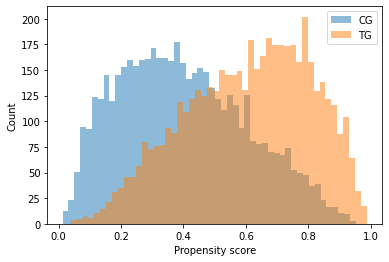

In [ ]:
# 真の傾向スコアの分布
prop_score_dist(df, "e_true")

## 2. 単純な群間比較

In [ ]:
# 群ごとの平均値の差
effect_naive = df.groupby("z")["y"].mean()[1] - df.groupby("z")["y"].mean()[0]
effect_naive

3.5633457373810558

In [ ]:
# 結果変数の介入変数への単回帰(OLS)でも同じ結果を得る
reg_ols(df["y"], df["z"])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     401.4
Date:                Tue, 01 Nov 2022   Prob (F-statistic):           1.44e-87
Time:                        13:37:04   Log-Likelihood:                -36041.
No. Observations:               10000   AIC:                         7.209e+04
Df Residuals:                    9998   BIC:                         7.210e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         76.6451      0.127    605.842      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## 3. 傾向スコアの推定
- 手法：ロジスティック回帰

In [ ]:
# ロジスティック回帰
Y = df["z"]
X = sm.add_constant(df[["x1", "x2", "x3", "x4"]])
model_logit = sm.Logit(Y, X)
result_logit = model_logit.fit()

# 傾向スコアの推定値
df["e_hat"] = model_logit.predict(result_logit.params)

# 推定結果
print(result_logit.summary())

Optimization terminated successfully.
         Current function value: 0.578574
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      z   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9995
Method:                           MLE   Df Model:                            4
Date:                Tue, 01 Nov 2022   Pseudo R-squ.:                  0.1652
Time:                        13:37:21   Log-Likelihood:                -5785.7
converged:                       True   LL-Null:                       -6930.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0179      0.038     -0.466      0.641      -0.093       0.057
x1            -0.8244      0.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


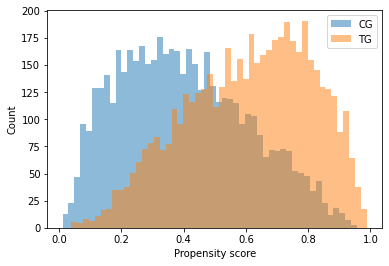

In [ ]:
# 傾向スコア推定値の分布
prop_score_dist(df, "e_hat")

## 4. 傾向スコアマッチング
- 最近傍マッチング
  - 傾向スコアの差が0.1より大きい場合はマッチさせないことにする

### 非復元抽出の場合

In [ ]:
#インスタンス作成
matching_result_nrep = (
    PropensityScoreMatching(
        df = df,                                      # データフレーム
        uid = "user_id",                              # user_id
        cov_list = cov_list_all["cov_name"].tolist(), # 特徴量リスト
        z = "z",                                      # 介入変数
        ps = "e_hat",                                 # 傾向スコアの推定値
        rs = "y",                                     # 結果変数
        nrep = 1                                      # If nrep = 1, 非復元抽出を実行, otherwise, 復元抽出を実行
    )
)

In [ ]:
# マッチング後のユーザリスト
df_after_matching_nrep = matching_result_nrep.matched_user_list()

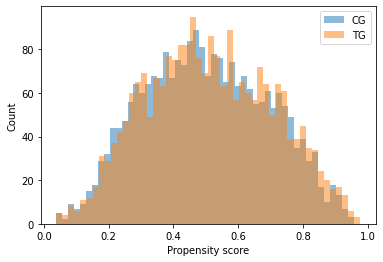

In [ ]:
# マッチング後の傾向スコアの分布
prop_score_dist(df_after_matching_nrep, "e_hat")

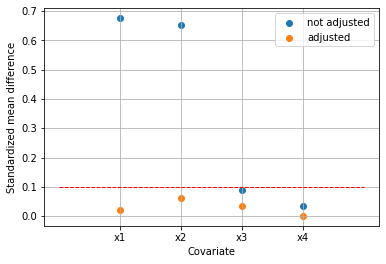

,index,before,after
0,x1,0.674972,0.019904
1,x2,0.652676,0.060540
2,x3,0.090942,0.034289
3,x4,0.033986,0.000857


In [ ]:
# 標準化平均差
matching_result_nrep.standardized_difference()

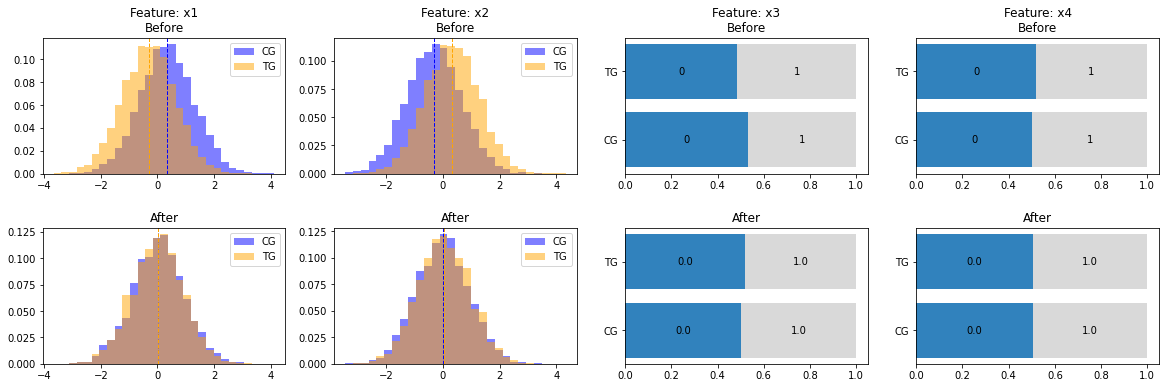

In [ ]:
# 調整前後における各特徴量の分布
covariate_dist(df, df_after_matching_nrep, cov_list_all)

In [ ]:
# 傾向スコアマッチング（非復元抽出）による効果推定値
effect_matching_nrep = matching_result_nrep.get_effect()
effect_matching_nrep

-4.625686851985904

In [ ]:
# マッチング後のデータを用いた，結果変数の介入変数への単回帰(OLS)でも同じ結果を得る．
reg_ols(df_after_matching_nrep["y"], df_after_matching_nrep["z"])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     391.3
Date:                Tue, 01 Nov 2022   Prob (F-statistic):           1.06e-83
Time:                        13:39:21   Log-Likelihood:                -16323.
No. Observations:                4668   AIC:                         3.265e+04
Df Residuals:                    4666   BIC:                         3.266e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.7938      0.165    488.622      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### 復元抽出の場合

In [ ]:
#インスタンス作成
matching_result_rep = (
    PropensityScoreMatching(
        df = df,                                      # データフレーム
        uid = "user_id",                              # user_id
        cov_list = cov_list_all["cov_name"].tolist(), # 特徴量リスト
        z = "z",                                      # 介入変数
        ps = "e_hat",                                 # 傾向スコアの推定値
        rs = "y",                                     # 結果変数
        nrep = 0                                      # If nrep = 1, 非復元抽出を実行, otherwise, 復元抽出を実行
    )
)

In [ ]:
# マッチング後のユーザリスト
df_after_matching_rep = matching_result_rep.matched_user_list()

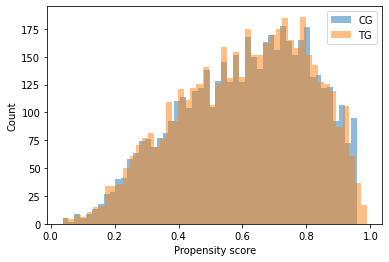

In [ ]:
# マッチング後の傾向スコアの分布
prop_score_dist(df_after_matching_rep, "e_hat")

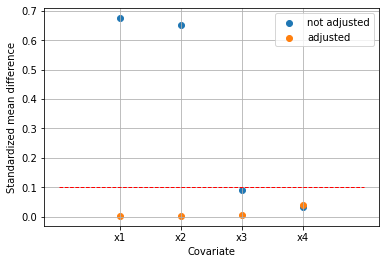

,index,before,after
0,x1,0.674972,0.002632
1,x2,0.652676,0.003955
2,x3,0.090942,0.006075
3,x4,0.033986,0.040895


In [ ]:
# 標準化平均差
matching_result_rep.standardized_difference()

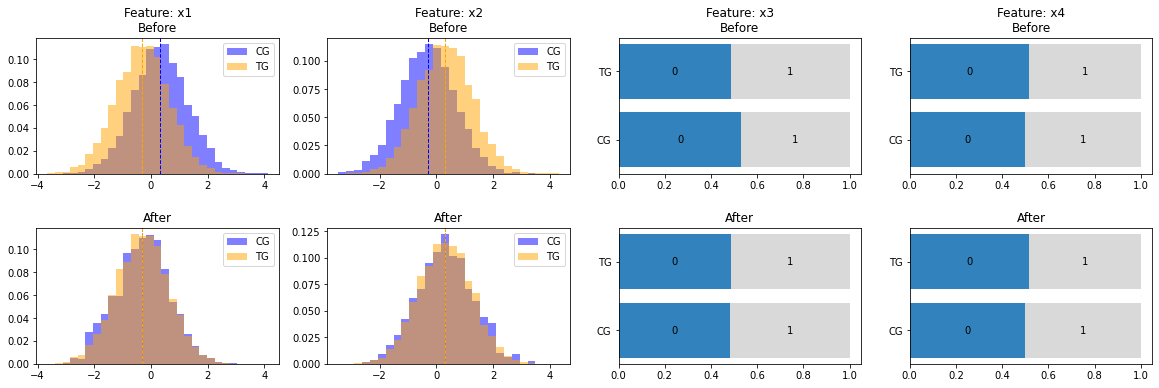

In [ ]:
# 調整前後における各特徴量の分布
covariate_dist(df, df_after_matching_rep, cov_list_all)

In [ ]:
# 傾向スコアマッチング（復元抽出）による効果推定値
effect_matching_rep = matching_result_rep.get_effect()
effect_matching_rep

-4.9428738301575095

In [ ]:
# マッチング後のデータを用いた，結果変数の介入変数への単回帰(OLS)でも同じ結果を得る．
reg_ols(df_after_matching_rep["y"], df_after_matching_rep["z"])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     784.8
Date:                Tue, 01 Nov 2022   Prob (F-statistic):          3.08e-166
Time:                        13:41:09   Log-Likelihood:                -35478.
No. Observations:                9882   AIC:                         7.096e+04
Df Residuals:                    9880   BIC:                         7.097e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         85.1594      0.125    682.561      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## 5. IPW (Inverse Probability Weighting)

In [ ]:
# インスタンス作成
ipw_result = (
    Weighting(
        df = df,                                      # データフレーム
        cov_list = cov_list_all["cov_name"].tolist(), # 特徴量リスト
        z = "z",                                      # 介入変数
        ps = "e_hat",                                 # 傾向スコアの推定値
        rs = "y",                                     # 結果変数
        ow = 0                                        # IF ow = 1, OW estimator is computed, otherwise IPW estimator is computed
    )
)

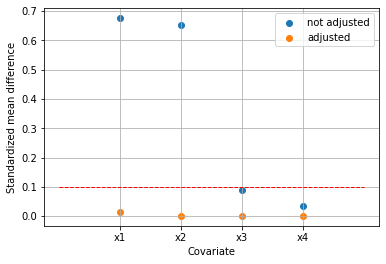

,index,Before,After
0,x1,0.674972,0.013099
1,x2,0.652676,0.001973
2,x3,0.090942,0.001426
3,x4,0.033986,0.000975


In [ ]:
# 標準化平均差
ipw_result.standardized_difference()

In [ ]:
# IPWによる効果推定値
effect_ipw = ipw_result.get_effect()
effect_ipw

-4.876353531195079

In [ ]:
# Weighted Least Squares(WLS)でも同じ結果を得る
reg_wls(df["y"], df["z"], 0)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.058
Model:                            WLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     619.2
Date:                Tue, 01 Nov 2022   Prob (F-statistic):          1.13e-132
Time:                        13:41:31   Log-Likelihood:                -37575.
No. Observations:               10000   AIC:                         7.515e+04
Df Residuals:                    9998   BIC:                         7.517e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.9998      0.138    586.243      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## 6. OW (Overlap Weighting)

In [ ]:
#インスタンス作成
ow_result = (
    Weighting(
        df = df,                                      # データフレーム
        cov_list = cov_list_all["cov_name"].tolist(), # 特徴量リスト
        z = "z",                                      # 介入変数
        ps = "e_hat",                                 # 傾向スコアの推定値
        rs = "y",                                     # 結果変数
        ow = 1                                        # IF ow = 1, OW estimator is computed, otherwise IPW estimator is computed 
    )
)

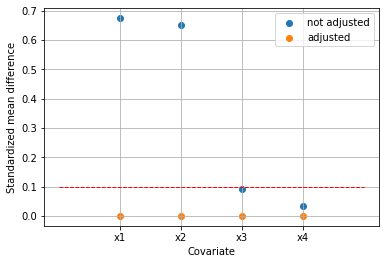

,index,Before,After
0,x1,0.674972,2.315136e-17
1,x2,0.652676,3.972070e-17
2,x3,0.090942,5.551566e-16
3,x4,0.033986,5.551050e-16


In [ ]:
# 標準化平均差
# Exact balance property: exactに0ではないが，極めて小さい値になっている
ow_result.standardized_difference()

In [ ]:
# OWによる効果推定値
effect_ow = ow_result.get_effect()
effect_ow

-4.986566062369647

In [ ]:
# Weighted Least Squares(WLS)でも同じ結果を得る
reg_wls(df["y"], df["z"], 1)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            WLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     963.1
Date:                Tue, 01 Nov 2022   Prob (F-statistic):          5.86e-202
Time:                        13:41:43   Log-Likelihood:                -35871.
No. Observations:               10000   AIC:                         7.175e+04
Df Residuals:                    9998   BIC:                         7.176e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.9364      0.114    712.343      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## 各手法での効果推定値

In [ ]:
# 各手法での効果推定値をデータフレームにまとめる
estimates = pd.DataFrame(
    {
    "Estimates": [effect_true, 
                  effect_naive, 
                  effect_matching_nrep, 
                  effect_matching_rep, 
                  effect_ipw, 
                  effect_ow]
    }, 
    index = ["真の効果", 
             "単純な群間比較", 
             "最近傍マッチング（非復元抽出）", 
             "最近傍マッチング（復元抽出）", 
             "Inverse Probability Weighting (IPW)", 
             "Overlap Weighting (OW)"]
)
estimates

,Estimates
真の効果,-5.000000
単純な群間比較,3.563346
最近傍マッチング（非復元抽出）,-4.625687
最近傍マッチング（復元抽出）,-4.942874
Inverse Probability Weighting (IPW),-4.876354
Overlap Weighting (OW),-4.986566
